# Apr 30th, 2022 (Misc KABA, 128 * 3)

**Motivation**: Make group plots (KABA) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(tr1, tr2, vmin=0.1, vmax=None, figsize=(13.5, 4), cmap='magma'):
    num = max(len(tr1['proj-top']), len(tr2['proj-top']))
    fig, axes = create_figure(2, num, figsize)
    for i in range(num):

        ax = axes[0, i]
        if i >= len(tr1['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr1['top'] == 0, tr1['top']), cmap='Greys_r')
            if np.nanmax(tr1['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr1['proj-top'][i] < vmin, tr1['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

        ax = axes[1, i]
        if i >= len(tr2['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr2['top'] == 0, tr2['top']), cmap='Greys_r')
            if np.nanmax(tr2['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr2['proj-top'][i] < vmin, tr2['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

    remove_ticks(axes)
    plt.show()

## Fig dir

In [3]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

### K = 15, p = 25

In [4]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 15, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [6]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

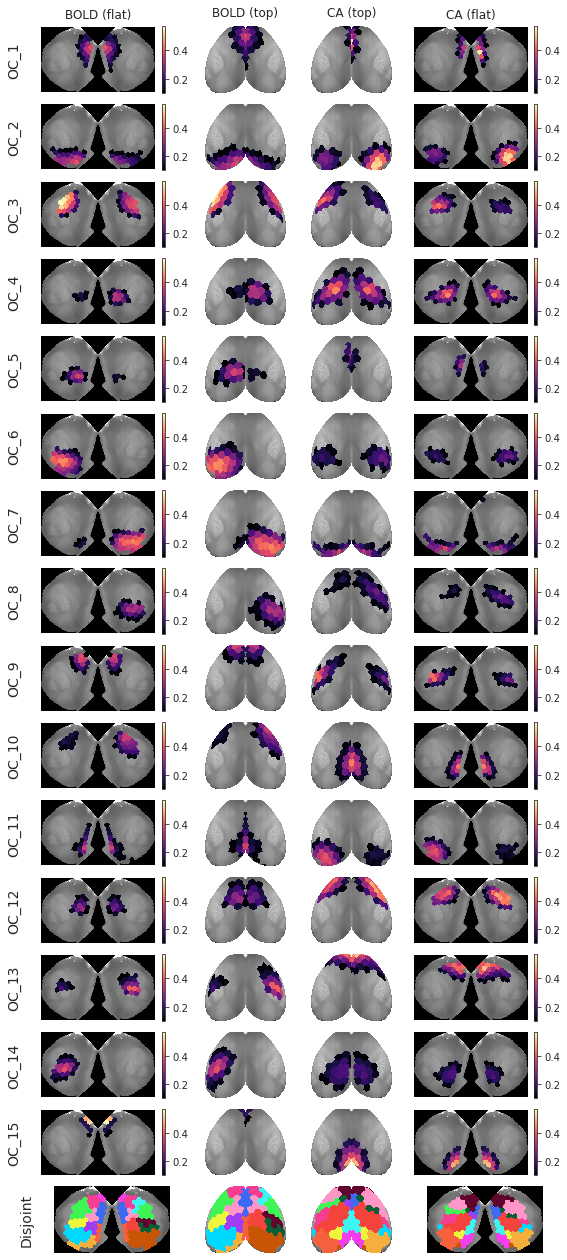

In [7]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [8]:
# idx_1, idx_2 = 5, 10
pi = gr_bo.pi.copy()

# pi[idx_1][pi[idx_1] < 0.1] = 0
# pi[idx_2][pi[idx_2] < 0.1] = 0
# pi[idx_1] += pi[idx_2]
# pi = pi[np.delete(range(num_k), idx_2)]
# pi = pi / np.nansum(pi, -2, keepdims=True)
# pi = pi[[0, 5, 2, 3, 6, 9, 4, 7, 8, 1]]
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [9]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

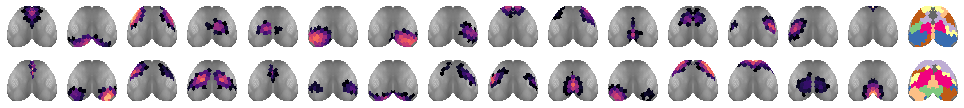

In [10]:
quick_show(tr, tr_ca, vmin=0.12, vmax=0.6, figsize=(13.5, 1.8))

In [11]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca, 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca, 'correlation'))

sim_corr.diagonal().mean(), sim_cos.diagonal().mean()

(0.22035009250466656, 0.5133969315039946)

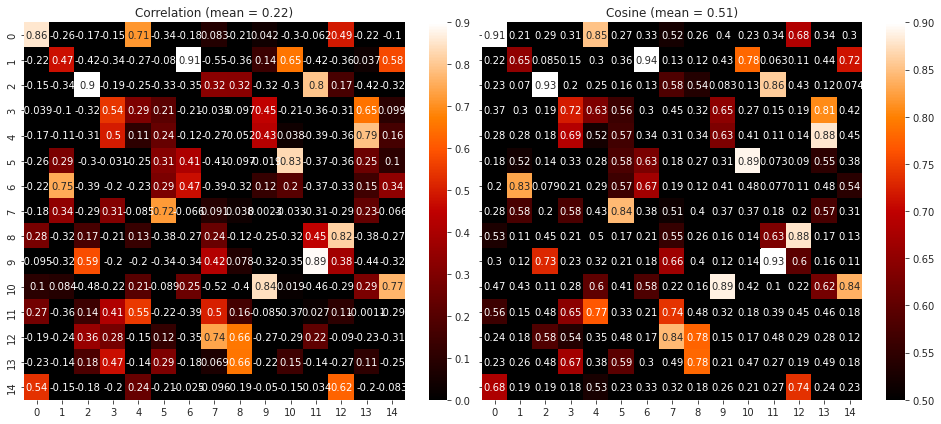

In [12]:
fig, axes = create_figure(1, 2, (13.5, 6.), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0.5, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [13]:
gmap = find_best_match(sim_cos, global_order=False)
gmap = list(gmap.values())
gmap += [i for i in range(len(pi_ca)) if i not in gmap]
gmap

[0, 6, 2, 13, 3, 10, 1, 5, 12, 11, 9, 4, 7, 8, 14]

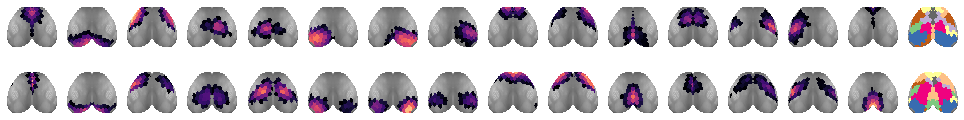

In [19]:
quick_show(
    tr,
    gr_ca.trim2d(gr_ca.project_vec(pi_ca[gmap])),
    vmin=0.08,
    vmax=0.6,
    figsize=(13.5, 2.3),
)

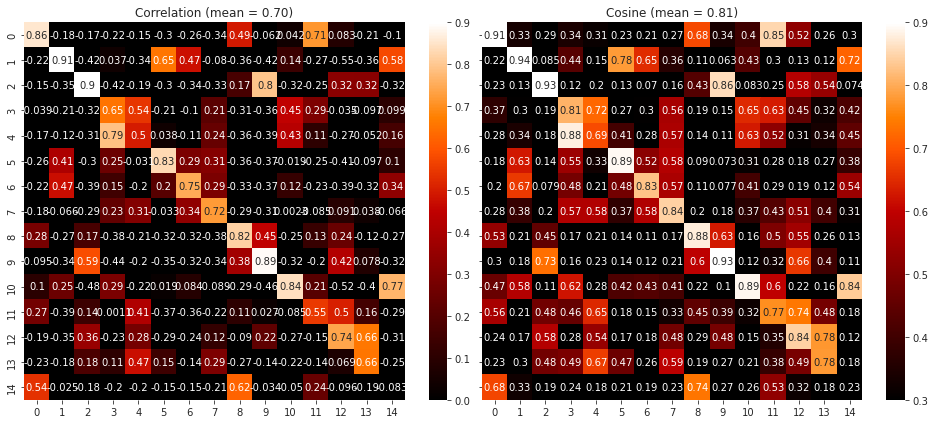

In [20]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'correlation'))

fig, axes = create_figure(1, 2, (13.5, 6), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0.3, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [21]:
sim_cos.diagonal()

array([0.90965838, 0.94476281, 0.93362208, 0.80897372, 0.68891875,
       0.89098225, 0.82882552, 0.84398334, 0.87836167, 0.92708892,
       0.88899753, 0.76723698, 0.84449265, 0.77998194, 0.22639209])

### K = 11, p = 25

In [4]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 11, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [6]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

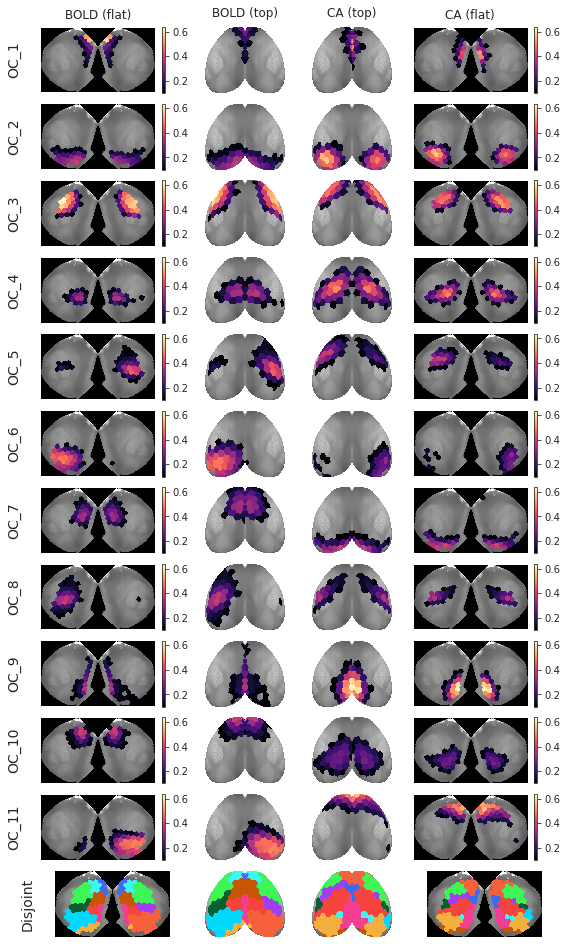

In [7]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [47]:
idx_1, idx_2 = 5, 10
pi = gr_bo.pi.copy()

pi[idx_1][pi[idx_1] < 0.1] = 0
pi[idx_2][pi[idx_2] < 0.1] = 0
pi[idx_1] += pi[idx_2]
pi = pi[np.delete(range(num_k), idx_2)]
pi = pi / np.nansum(pi, -2, keepdims=True)
pi = pi[[0, 5, 2, 3, 6, 9, 4, 7, 8, 1]]
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [48]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

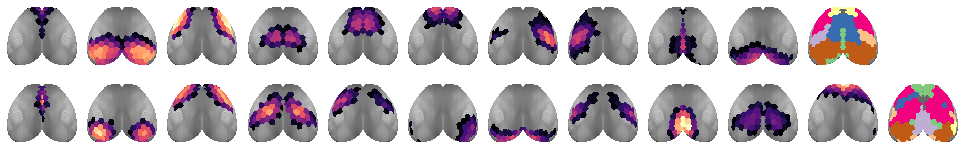

In [49]:
quick_show(tr, tr_ca, vmin=0.12, vmax=0.6, figsize=(13.5, 2.4))

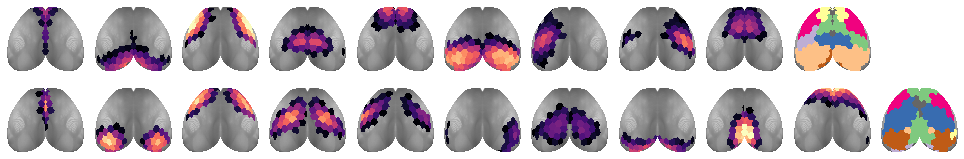

In [50]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca, 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca, 'correlation'))

sim_corr.diagonal().mean(), sim_cos.diagonal().mean()

(0.3696851808670735, 0.6468475174376165)

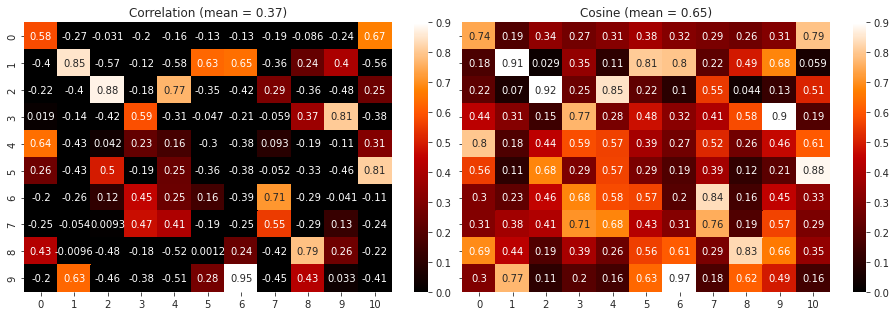

In [51]:
fig, axes = create_figure(1, 2, (13, 4.5), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [52]:
gmap = find_best_match(sim_cos, global_order=False)
gmap = list(gmap.values())
gmap += [i for i in range(len(pi_ca)) if i not in gmap]
gmap

[10, 1, 2, 9, 0, 4, 7, 3, 8, 6, 5]

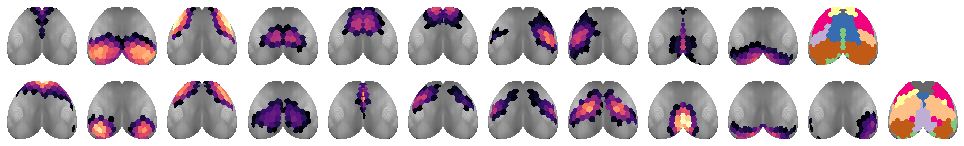

In [53]:
quick_show(
    tr,
    gr_ca.trim2d(gr_ca.project_vec(pi_ca[gmap])),
    vmin=0.12,
    vmax=0.6,
    figsize=(13.5, 2.3),
)

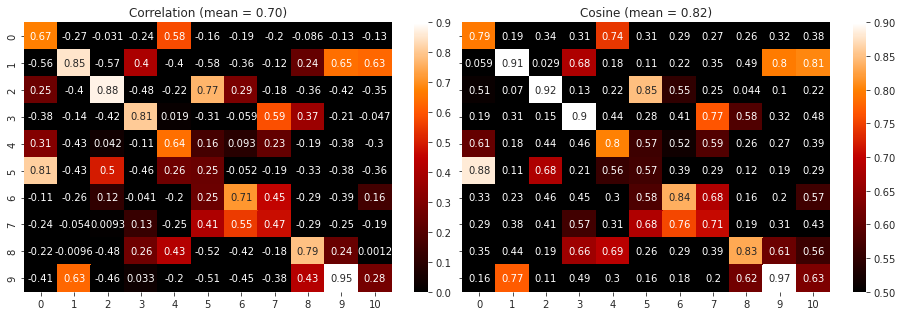

In [54]:
sim_cos = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'cosine'))
sim_corr = dist2sim(sp_dist.cdist(pi, pi_ca[gmap], 'correlation'))

fig, axes = create_figure(1, 2, (13, 4.5), 'all', 'all')
sns.heatmap(sim_corr, cmap='gist_heat', annot=True, vmin=0, vmax=0.9, ax=axes[0])
sns.heatmap(sim_cos, cmap='gist_heat', annot=True, vmin=0.5, vmax=0.9, ax=axes[1])
axes[0].set_title(f'Correlation (mean = {sim_corr.diagonal().mean():0.2f})')
axes[1].set_title(f'Cosine (mean = {sim_cos.diagonal().mean():0.2f})')
plt.show()

In [55]:
sim_cos.diagonal()

array([0.79404648, 0.90513049, 0.91732275, 0.90053185, 0.80130192,
       0.56812841, 0.83701215, 0.7072357 , 0.83258043, 0.96962392])

### K = 10, p = 25

In [4]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 10, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [6]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

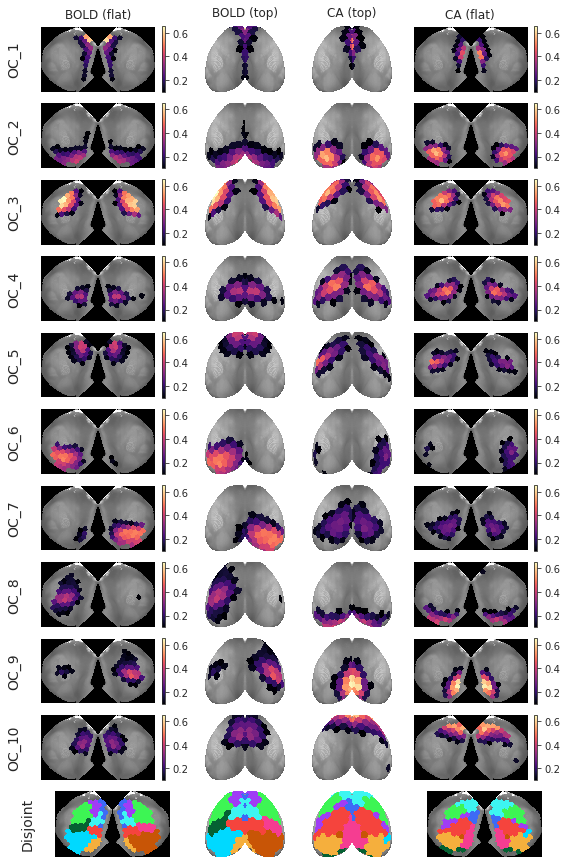

In [7]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [41]:
idx_1, idx_2 = 5, 6
pi = gr_bo.pi.copy()

pi[idx_1][pi[idx_1] < 0.1] = 0
pi[idx_2][pi[idx_2] < 0.1] = 0
pi[idx_1] += pi[idx_2]
pi = pi[np.delete(range(num_k), idx_2)]
pi = pi / np.nansum(pi, -2, keepdims=True)
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [42]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

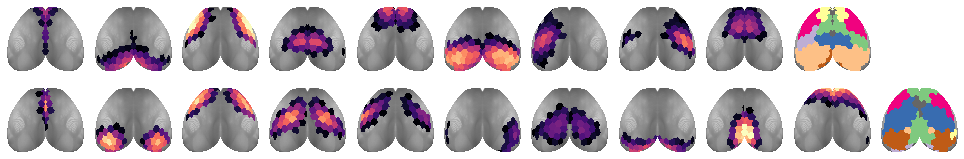

In [43]:
quick_show(tr, tr_ca, vmin=0.12, vmax=0.6, figsize=(13.5, 2.5))

### K = 8, p = 25

In [4]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 8, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [5]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [6]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

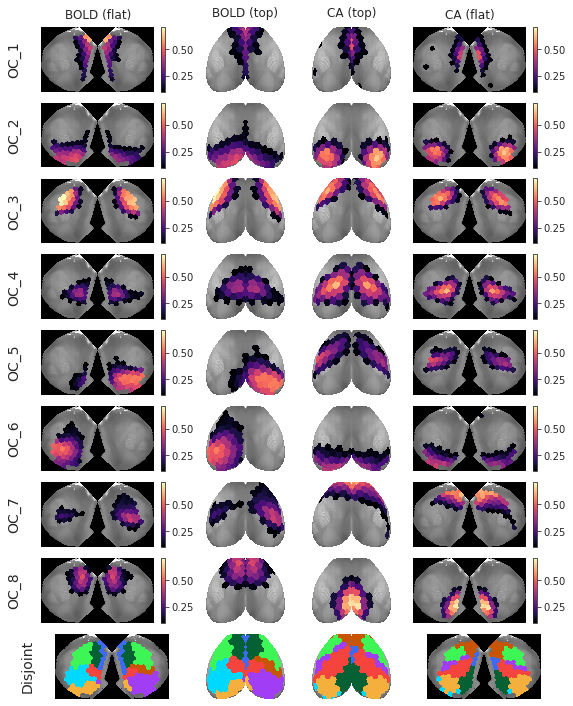

In [7]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [8]:
idx_1, idx_2 = 4, 5
pi = gr_bo.pi.copy()
pi[idx_1] *= 0.5
pi[idx_2] *= 0.5

#pi[1][pi[1] < 0.1] = 0
#pi[4][pi[4] < 0.1] = 0
pi[idx_1] += pi[idx_2]
pi = pi[np.delete(range(num_k), idx_2)]
pi = pi / np.nansum(pi, -2, keepdims=True)
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [9]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

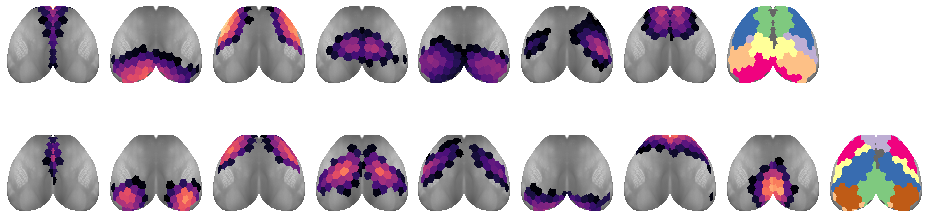

In [10]:
quick_show(tr, tr_ca, vmin=0.15, vmax=0.8)

### K = 7, p = 25

In [11]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 7, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [12]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [13]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

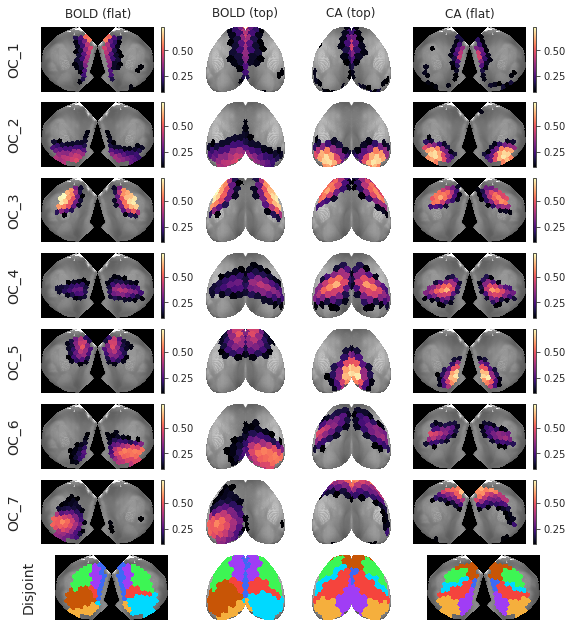

In [14]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [15]:
idx_1, idx_2 = 5, 6
pi = gr_bo.pi.copy()
pi[idx_1] *= 0.5
pi[idx_2] *= 0.5

#pi[1][pi[1] < 0.1] = 0
#pi[4][pi[4] < 0.1] = 0
pi[idx_1] += pi[idx_2]
pi = pi[np.delete(range(num_k), idx_2)]
pi = pi / np.nansum(pi, -2, keepdims=True)
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [18]:
pi_ca = gr_ca.pi[[0, 1, 2, 3, 6, 4, 5]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

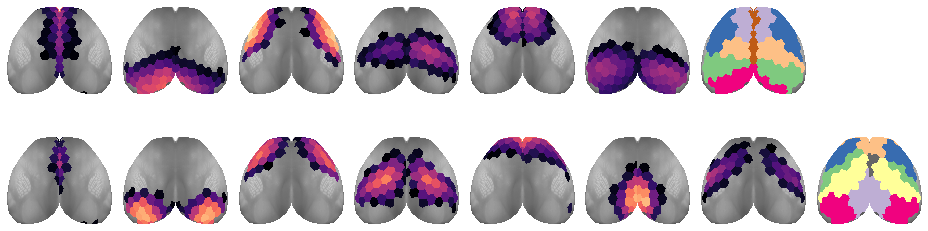

In [20]:
quick_show(tr, tr_ca, vmin=0.15, vmax=0.8)

### K = 6, p = 25

In [21]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 6, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [22]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [23]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

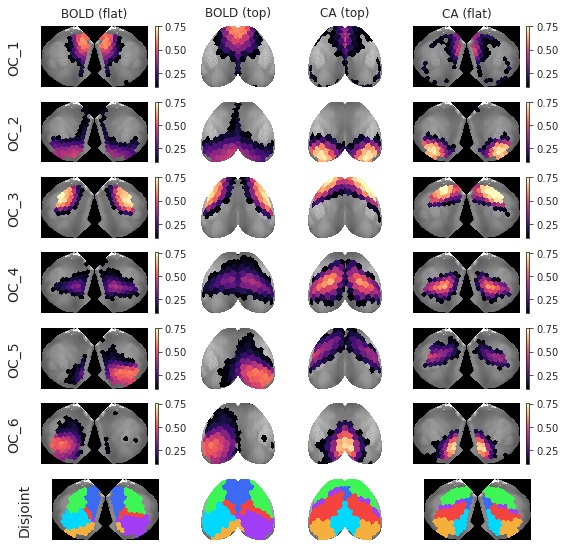

In [24]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [25]:
idx_1, idx_2 = 4, 5
pi = gr_bo.pi.copy()
pi[idx_1] *= 0.5
pi[idx_2] *= 0.5

#pi[1][pi[1] < 0.1] = 0
#pi[4][pi[4] < 0.1] = 0
pi[idx_1] += pi[idx_2]
pi = pi[np.delete(range(num_k), idx_2)]
pi = pi / np.nansum(pi, -2, keepdims=True)
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [26]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

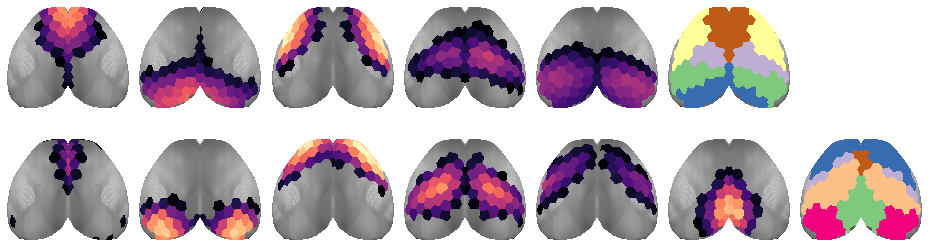

In [27]:
quick_show(tr, tr_ca, vmin=0.15, vmax=0.8)

### K = 5, p = 25

In [28]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 5, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [29]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [30]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

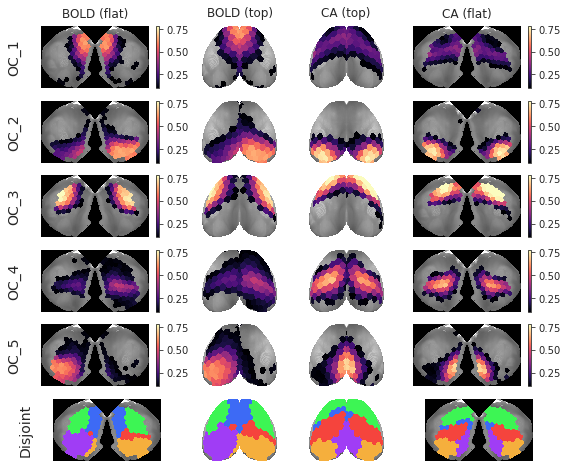

In [31]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [32]:
idx_1, idx_2 = 1, 4
pi = gr_bo.pi.copy()
pi[idx_1] *= 0.5
pi[idx_2] *= 0.5

#pi[1][pi[1] < 0.1] = 0
#pi[4][pi[4] < 0.1] = 0
pi[idx_1] += pi[idx_2]
pi = pi[np.delete(range(num_k), idx_2)]
pi = pi / np.nansum(pi, -2, keepdims=True)
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [33]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

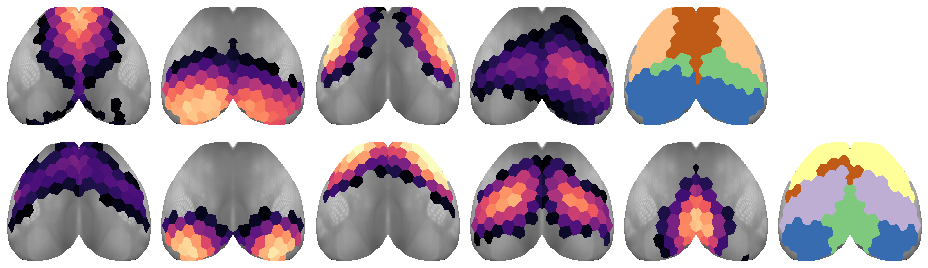

In [34]:
quick_show(tr, tr_ca, vmin=0.15, vmax=0.8)

### K = 4, p = 25

In [35]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, p = 4, 25
perc = f'p{p}-sample'
props_base = {
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [36]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [37]:
gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

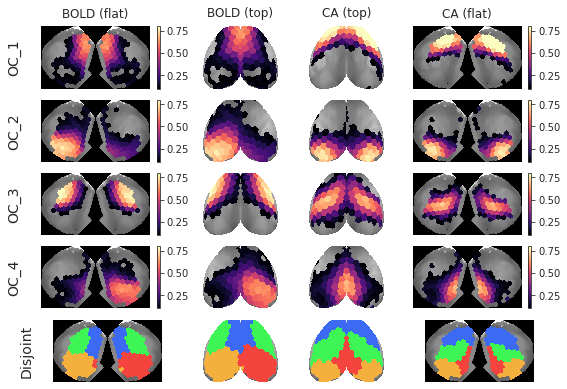

In [38]:
proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [39]:
idx_1, idx_2 = 1, 3
pi = gr_bo.pi.copy()
pi[idx_1] *= 0.5
pi[idx_2] *= 0.5

#pi[1][pi[1] < 0.1] = 0
#pi[4][pi[4] < 0.1] = 0
pi[idx_1] += pi[idx_2]
pi = pi[np.delete(range(num_k), idx_2)]
pi = pi / np.nansum(pi, -2, keepdims=True)
tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [40]:
pi_ca = gr_ca.pi# [[0, 1, 2, 4, 3]]
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

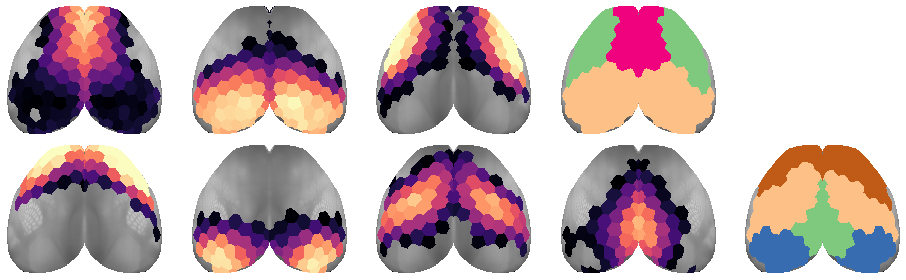

In [41]:
quick_show(tr, tr_ca, vmin=0.15, vmax=0.8)

BOLD (corr)   : : :   ovp: 0.7107,  disj: 0.8571

Ca2  (corr)   : : :   ovp: 0.9763,  disj: 0.9610

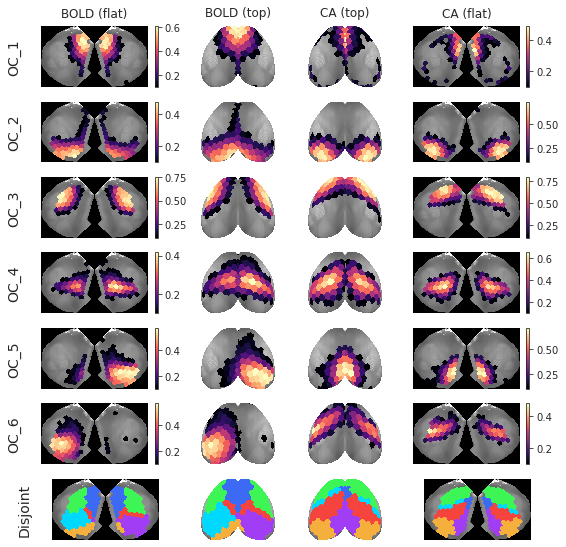

Similarity between OCs (correlation):  Avg = 0.566
OC1: 0.82, OC2: 0.74, OC3: 0.73, OC4: 0.82, OC5: 0.37, OC6: -0.09,

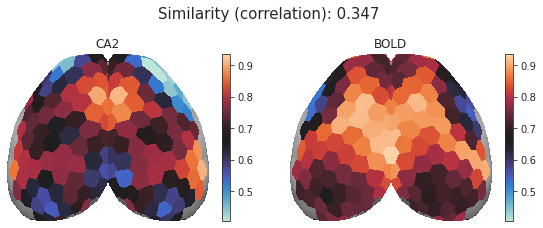

-------------------------------------------------------------------------------

CPU times: user 7min 22s, sys: 26.2 s, total: 7min 48s
Wall time: 2min 3s


In [5]:
%%time

gr_ca = Group(**props_ca).fit_group(force=True)
gr_bo = Group(**props_bo).fit_group(force=True)
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)

sim = dist2sim(sp_dist.cdist(
    XA=gr_bo.pi,
    XB=gr_ca.pi,
    metric='correlation',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bo.pi = gr_bo.pi
gr_ca.pi = gr_ca.pi[ids]

proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

h_ca = sp_stats.entropy(gr_ca.pi) / np.log(num_k)
h_bo = sp_stats.entropy(gr_bo.pi) / np.log(num_k)
h = np.concatenate([np.expand_dims(h_ca, 0), np.expand_dims(h_bo, 0)])
proj = gr_ca.project_vec(h, add_disjoint=False)
tr = gr_ca.trim2d(proj)

ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=False,
    min_thres=0.1,
)
score = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
msg = f'Similarity between OCs (correlation):  Avg = {score.mean():0.3f}\n'
for i in range(num_k):
    msg += f'OC{i+1}: {score[i]:0.2f}, '
msg += '\n'
print(msg)

vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

fig, axes = create_figure(1, 2, (8, 3))
for ax in axes.flat:
    ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
plt.colorbar(im, ax=axes[0])
axes[0].set_title('CA2')
im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
plt.colorbar(im, ax=axes[1])
axes[1].set_title('BOLD')
sim_h = sp_stats.pearsonr(h_ca, h_bo)[0]
fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
remove_ticks(axes)
plt.show()

print('-' * 79)
print('\n\n')

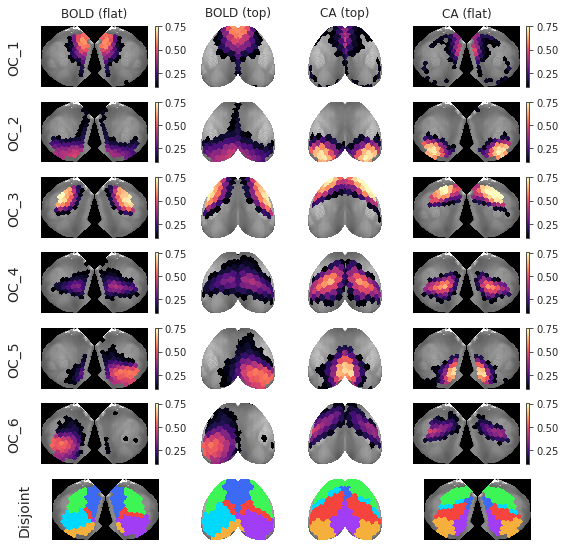

In [6]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.1,
)

In [78]:
pi_reduc = gr_bo.pi.copy()
pi_reduc[-1, pi_reduc[-1] < 0.2] = 0
pi_reduc[-2, pi_reduc[-2] < 0.2] = 0
pi_reduc[1, pi_reduc[1] < 0.15] = 0
pi_reduc[1] += pi_reduc[-1] + pi_reduc[-2]
pi_reduc = pi_reduc[:-2]
pi_reduc = pi_reduc / np.nansum(pi_reduc, -2, keepdims=True)
pi_reduc.shape

(4, 154)

In [79]:
tr_reduc = gr_bo.project_vec(pi_reduc)
tr_reduc = gr_bo.trim2d(tr_reduc)

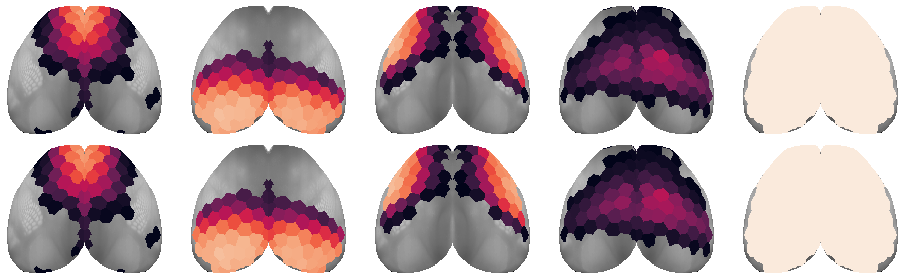

In [82]:
quick_show(tr_reduc, tr_reduc, vmax=1)

<AxesSubplot:ylabel='Count'>

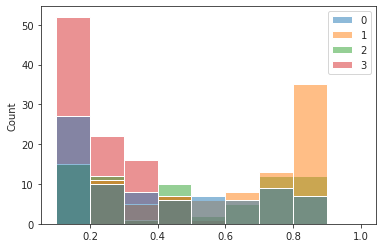

In [89]:
sns.histplot(pi_reduc.T, bins=np.linspace(0.1, 1.0, 10))

<AxesSubplot:ylabel='Count'>

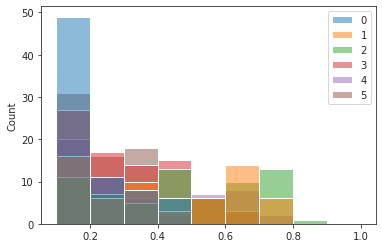

In [91]:
sns.histplot(gr_ca.pi.T, bins=np.linspace(0.1, 1.0, 10))

In [101]:
cut_ca = cut_data(
    data=bn.nanmean(gr_ca.run_pi, -3).reshape(-1, 6, 154),
    bins=np.linspace(0.1, 1.0, 10),
    oc_only=True,
)[0].reshape(10, 3, 4, 6, -1)
cut_avg_ca = bn.nanmean(bn.nanmean(bn.nanmean(cut_ca, 2), 1), 0)
cut_ca.shape, cut_avg_ca.shape

((10, 3, 4, 6, 9), (6, 9))

In [103]:
cut_avg_ca[:, -1]

array([ 0.70530908, 17.70464016, 17.05816393,  0.6476007 ,  0.36830159,
       11.36145726])

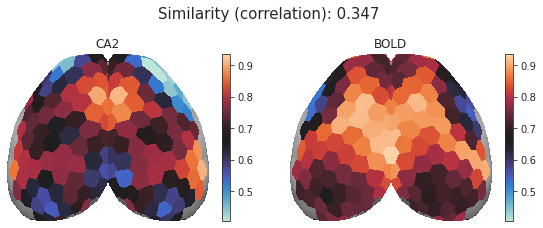

In [55]:
h_ca = sp_stats.entropy(gr_ca.pi) / np.log(num_k)
h_bo = sp_stats.entropy(gr_bo.pi) / np.log(len(gr_bo.pi))
h = np.concatenate([np.expand_dims(h_ca, 0), np.expand_dims(h_bo, 0)])
proj = gr_ca.project_vec(h, add_disjoint=False)
tr = gr_ca.trim2d(proj)

vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

fig, axes = create_figure(1, 2, (8, 3))
for ax in axes.flat:
    ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
plt.colorbar(im, ax=axes[0])
axes[0].set_title('CA2')
im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
plt.colorbar(im, ax=axes[1])
axes[1].set_title('BOLD')
sim_h = sp_stats.pearsonr(h_ca, h_bo)[0]
fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
remove_ticks(axes)
plt.show()

<AxesSubplot:ylabel='Count'>

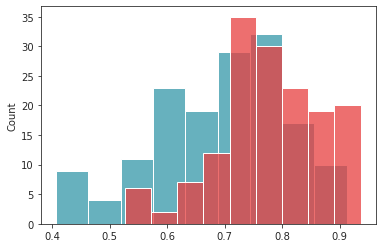

In [60]:
sns.histplot(h_ca, color=pal['ca2'])
sns.histplot(h_bo, color=pal['bold-lite'])

In [61]:
run_h_bo = sp_stats.entropy(gr_bo.run_pi, axis=-2) / np.log(num_k)
run_h_ca = sp_stats.entropy(gr_ca.run_pi, axis=-2) / np.log(num_k)

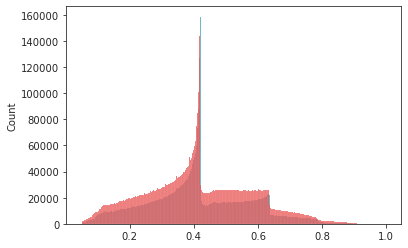

In [68]:
sns.histplot(run_h_ca[run_h_ca > 0.05], color=pal['ca2'])
sns.histplot(run_h_bo[run_h_bo > 0.05], color=pal['bold-lite'])
plt.show()

In [73]:
i = 5
sp_stats.entropy([0.5] * 2 + [0] * (i - 2)) / np.log(i)

0.43067655807339306

In [74]:
i = 5
sp_stats.entropy([0.5] * 3 + [0] * (i - 3)) / np.log(i)

0.6826061944859853

In [5]:
pi_infer = gr_ca.run_gam / np.nansum(gr_ca.run_gam, -2, keepdims=True)

In [7]:
np.array_equal(gr_ca.run_pi, pi_infer)

False

In [6]:
i = 125389
gr_ca.run_pi.ravel()[i], pi_infer.ravel()[i]

(0.22301577464788727, 0.2230157746478873)

In [ ]:
getattr(gr_ca)

In [13]:
props_ca

{
    'mode': 'ca2',
    'perc': 'p25-sample',
    'num_k': 6,
    'mice': <model.mouse.Mice object at 0x7fc824fb7370>,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False
}

In [16]:
gr_ca.sv_props

{'match_metric': 'euclidean', 'match_using': 'gam', 'verbose': False}

In [8]:
gr_ca.sv_props

{'match_metric': 'euclidean', 'match_using': 'gam', 'verbose': False}

In [10]:
f"{gr_ca.sv_props['match_using']}_all"

'gam_all'

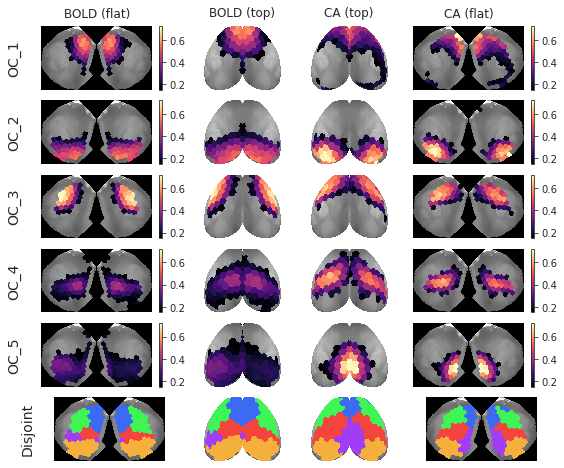

In [8]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.15,
)

In [25]:
x = gr_bo.run_centroids.copy()
x_avg = bn.nanmean(bn.nanmean(bn.nanmean(x, 2), 1), 0)
pi = x_avg / np.nansum(x_avg, -2, keepdims=True)

tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [26]:
x_reord = realign_data_runs(x)
x_reord_avg = bn.nanmean(bn.nanmean(bn.nanmean(x_reord, 2), 1), 0)
pi_reord = x_reord_avg / np.nansum(x_reord_avg, -2, keepdims=True)

tr_reord = gr_bo.project_vec(pi_reord)
tr_reord = gr_bo.trim2d(tr_reord)

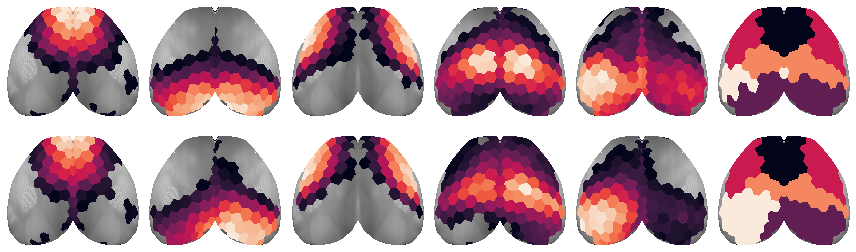

In [27]:
quick_show(tr, tr_reord)

In [28]:
h = sp_stats.entropy(pi, axis=-2) / np.log(5)
h_reord = sp_stats.entropy(pi_reord, axis=-2) / np.log(5)
h_both = np.concatenate([h.reshape(1, -1), h_reord.reshape(1, -1)])

tr_h = gr_bo.project_vec(h_both)
tr_h = gr_bo.trim2d(tr_h)

<matplotlib.image.AxesImage object at 0x7f9689d20310>

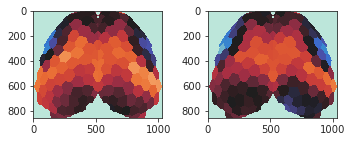

In [31]:
fig, axes = create_figure(1, 2, (5, 3))
axes[0].imshow(tr_h['proj-top'][0], vmin=0.5, vmax=1, cmap='icefire')
axes[1].imshow(tr_h['proj-top'][1], vmin=0.5, vmax=1, cmap='icefire')

In [32]:
x.shape

(10, 3, 4, 5, 154)

In [35]:
i, j, k = x.shape[:3]
data_reord = np_nans(x.shape)
looper = itertools.product(range(i), range(j), range(j))
data_cl = []
for i, j, k in looper:
    _x = x[i, j, k]
    good_nodes = np.where(np.isnan(_x).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    data_cl.append(_x)
data_cl = np.concatenate(data_cl)
data_cl.shape

(450, 154)

In [36]:
good_nodes = np.where(np.isnan(data_cl).sum(0) == 0)[0]
len(good_nodes)

117

(5, 154)

In [37]:
centroids_meta = np_nans((5, data_cl.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data_cl[:, good_nodes],
    n_clusters=5,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids_meta[:, good_nodes] = _centroids

In [40]:
global_mapping = gr_bo.align_centroid_to_structs(
    pi_mv=centroids_meta,
    dist_metric=gr_bo.dist_metric,
    global_order=False,
)
centroids_meta = centroids_meta[global_mapping]

In [42]:
pi_meta = centroids_meta / np.nansum(centroids_meta, -2, keepdims=True)
tr_meta = gr_bo.project_vec(pi_meta)
tr_meta = gr_bo.trim2d(tr_meta)

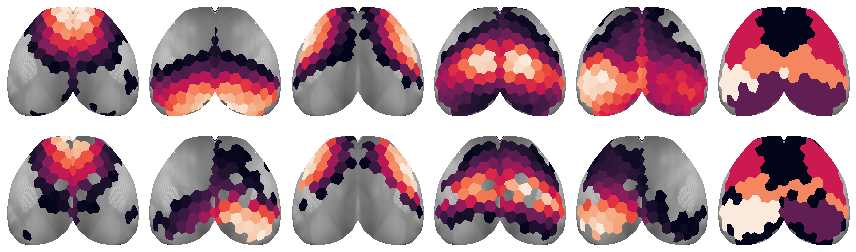

In [43]:
quick_show(tr, tr_meta)